<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Linear Models for Regression

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import math
import matplotlib.pyplot as plt

     |████████████████████████████████| 380.5MB 42kB/s 
     |████████████████████████████████| 4.3MB 36.2MB/s 
     |████████████████████████████████| 501kB 49.5MB/s 


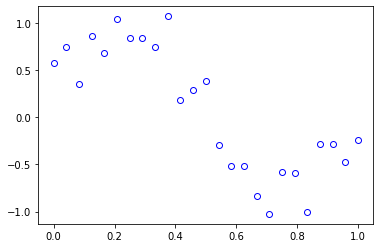

In [2]:
# 참고: https://github.com/ctgk/PRML

def sinusoidal(x):
  return tf.math.sin(2 * math.pi * x)

def linear(x):
  return -0.3 + 0.5 * x

def cubic(x):
  return x * (x - 5) * (x + 5)  

def create_toy_data(func, sample_size, std, domain=[0.0, 1.0]):
  x = tf.cast(tf.linspace(domain[0], domain[1], sample_size), tf.float64)
  x = tf.random.shuffle(x)
  t = func(x) + tf.random.normal(x.shape, stddev=std, dtype=tf.float64)
  return x, t

x, y = create_toy_data(sinusoidal, 25, 0.25)
plt.plot(x, y, 'bo', markerfacecolor='none')

## 3.1. Linear Basis Function Models

In [3]:
def polynomial_basis_functions(x, M):
  X = []
  for i in range(M):
    X.append(tf.math.pow(x, i))
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

print(polynomial_basis_functions(0.5, 4))
print(polynomial_basis_functions([-0.5, 0.0, 0.5], 6))

tf.Tensor([1.    0.5   0.25  0.125], shape=(4,), dtype=float64)
tf.Tensor(
[[ 1.      -0.5      0.25    -0.125    0.0625  -0.03125]
 [ 1.       0.       0.       0.       0.       0.     ]
 [ 1.       0.5      0.25     0.125    0.0625   0.03125]], shape=(3, 6), dtype=float64)


In [4]:
def gaussian_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.exp(-0.5 * tf.math.pow(tf.subtract(x, m), 2) / s**2)) # 식 3.4
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(gaussian_basis_functions(0.5, mu, s))
print(gaussian_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor(
[0.00000000e+00 5.31107191e-27 2.28973489e-11 1.11090122e-02
 6.06530488e-01 3.72665318e-06], shape=(6,), dtype=float64)
(3, 6)


In [5]:
def sigmoidal_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.sigmoid(tf.subtract(x, m) / s)) # 식 3.5
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(sigmoidal_basis_functions(0.5, mu, s))
print(sigmoidal_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor([0.99999964 0.99998331 0.999089   0.95257413 0.26894137 0.00669285], shape=(6,), dtype=float64)
(3, 6)


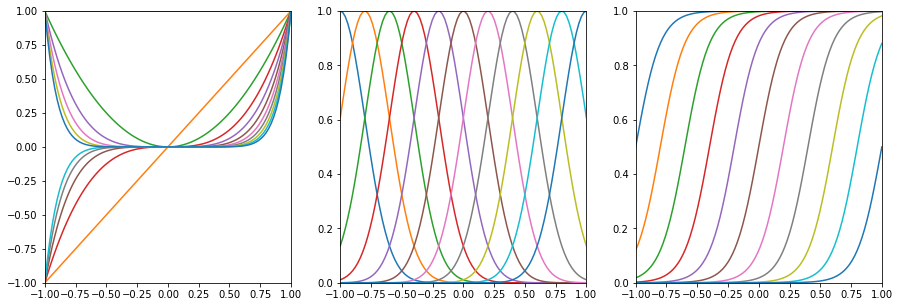

In [6]:
M = 11
mu = tf.linspace(-1.0, 1.0, M)
x = tf.linspace(-1.0, 1.0, 100)

X_polynomial = polynomial_basis_functions(x, M)
X_gaussian = gaussian_basis_functions(x, mu, 0.2)
X_sigmoidal = sigmoidal_basis_functions(x, mu, 0.1)

plt.figure(figsize=(15, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
  plt.subplot(1, 3, i + 1)
  for j in range(M):
    plt.plot(x, X[:, j])
  plt.xlim(-1,1); plt.ylim(tf.reduce_min(X).numpy(), tf.reduce_max(X).numpy())

### 3.1.1 Maximum likelihood and least squares

$$
\mathbf{w}_\text{ML} = (\Phi^T\Phi)^{-1}\Phi^T \mathsf{\bf{t}}
$$

In [7]:
x, t = create_toy_data(sinusoidal, 10, 0.2)
M = 2
design_mat = polynomial_basis_functions(x, M)
pseudo_inverse = tf.linalg.matmul(
    tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
    tf.transpose(design_mat)) # 식 3.17
w_ML = tf.linalg.matvec(pseudo_inverse, t) # 식 3.15
# w_ML = np.linalg.pinv(design_mat) @ t
print(w_ML)

tf.Tensor([ 0.61037597 -1.24641441], shape=(2,), dtype=float64)


$$
w_0 = \bar{t} - \Sigma_{j=1}^{M-1} w_j \bar{\phi_{j}}
$$

In [0]:
t_bar = tf.reduce_mean(t)
phi_j_bar = tf.reduce_mean(design_mat, axis=0)
sigma_term = w_ML * phi_j_bar
eq_3_19 = t_bar - tf.reduce_sum(sigma_term[1:]) # 식 3.19

assert(abs(w_ML[0] - eq_3_19) < 1.0e-6)

tf.Tensor(0.6103759701025059, shape=(), dtype=float64)


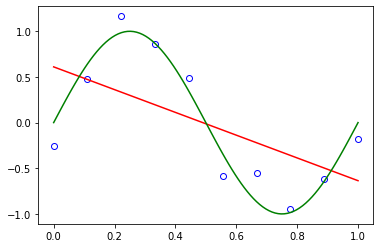

In [9]:
plot_x = tf.linspace(0.0, 1.0, 100)
design_mat = polynomial_basis_functions(plot_x, M)
plot_y = tf.linalg.matvec(design_mat, w_ML)

plt.plot(x, t, 'bo', markerfacecolor='none')
plt.plot(plot_x, plot_y, 'r')
plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')

print(w_ML[0])

In [0]:
x, t = create_toy_data(sinusoidal, 10, 0.25)
Ms = [1, 2, 4, 10]
w_ML = []
beta_ML = []
for M in Ms:
  design_mat = polynomial_basis_functions(x, M)
  pseudo_inverse = tf.linalg.matmul(
      tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
      tf.transpose(design_mat))
  w = tf.linalg.matvec(pseudo_inverse, t)
  beta = 1. / tf.reduce_mean(
    tf.math.square(t - tf.linalg.matvec(design_mat, w)))
  w_ML.append(w)
  beta_ML.append(beta) # 식 3.21

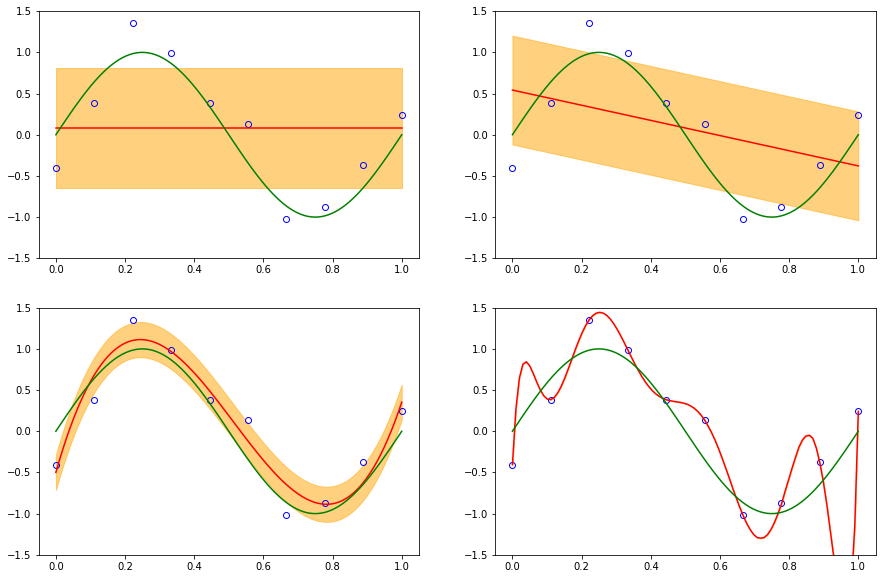

In [11]:
plt.figure(figsize=(15,10))
for i in range(len(w_ML)):
  w = w_ML[i]
  beta = beta_ML[i]
  target_std = tf.math.sqrt(1. / beta)

  plt.subplot(2, 2, i + 1)
  plot_x = tf.linspace(0.0, 1.0, 100)
  design_mat = polynomial_basis_functions(plot_x, len(w))
  plot_y = tf.linalg.matvec(design_mat, w)
  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.fill_between(
    plot_x, plot_y - target_std, plot_y + target_std,
    color="orange", alpha=0.5)
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')
  plt.ylim(-1.5, 1.5)

### 3.1.4 Regularized least squares

$$
L = \frac{1}{2} \Sigma_{n=1}^{N} \{t_n - \textbf{w}^\text{T} \phi(\textbf{x}_n) \}^2 + \frac{\lambda}{2} \textbf{w}^\text{T}\textbf{w}
$$

$$
\textbf{w}_\text{reg} = (\lambda \textbf{I} + \mathbf{\Phi}^\text{T}\mathbf{\Phi})^{-1}\mathbf{\Phi}^\text{T} \mathsf{\bf{t}}
$$

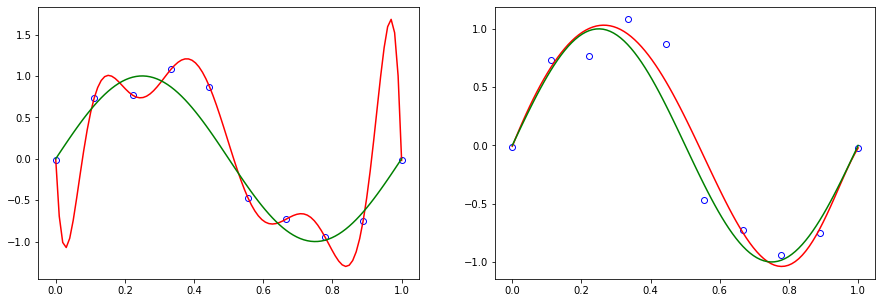

In [12]:
x, t = create_toy_data(sinusoidal, 10, 0.2)
M = 10
design_mat = polynomial_basis_functions(x, M)
pseudo_inverse = tf.linalg.matmul(
    tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
    tf.transpose(design_mat))
w_ML = tf.linalg.matvec(pseudo_inverse, t)

lamb = 1.e-4
I = tf.eye(M, dtype=tf.float64)
w_REG = tf.linalg.matvec(
    tf.linalg.matmul(
        tf.linalg.inv(
            tf.add(
                lamb * I,
                tf.linalg.matmul(tf.transpose(design_mat), design_mat))), 
        tf.transpose(design_mat)), 
    t) # 식 3.28
list_w = [w_ML, w_REG]

plt.figure(figsize=(15,5))
for i, w in enumerate(list_w):
  plt.subplot(1, 2, i+1)
  plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
  design_mat = polynomial_basis_functions(plot_x, M)
  plot_y = tf.linalg.matvec(design_mat, w)

  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')


## 3.2. The Bias-Variance Decomposition

In [0]:
L = 100
M = 25
N = 25

D = []
for i in range(L):
  x, t = create_toy_data(sinusoidal, N, 0.25)
  D.append({'x':x, 't':t})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


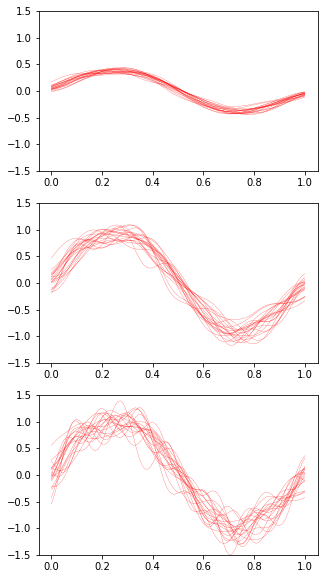

In [14]:
plt.figure(figsize=(5,10))
lamb_list = [tf.cast(tf.math.exp(2.6), tf.float64),
             tf.cast(tf.math.exp(-0.31), tf.float64),
             tf.cast(tf.math.exp(-3.4), tf.float64)]
for i, lamb in enumerate(lamb_list):
  for l in range(20):
    x, t = D[l]['x'], D[l]['t']
    phi = gaussian_basis_functions(
        x, tf.cast(tf.linspace(0.0, 1.0, M), tf.float64), 0.05)

    I = tf.eye(M, dtype=tf.float64)
    w = tf.linalg.matvec(
        tf.linalg.matmul(
            tf.linalg.inv(
                tf.add(
                    lamb * I,
                    tf.linalg.matmul(tf.transpose(phi), phi))), 
            tf.transpose(phi)), 
        t)
        
    ax = plt.subplot(3, 1, i+1)
    plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
    phi = gaussian_basis_functions(
        plot_x, 
        tf.cast(tf.linspace(0.0, 1.0, M), tf.float64), 0.05)
    plot_y = tf.linalg.matvec(phi, w)

    ax.plot(plot_x, plot_y, 'r', linewidth=0.2)
    plt.ylim(-1.5,1.5)

## 3.3. Bayesian Linear Regression

In [0]:
a0, a1 = -0.3, 0.5
alpha, beta = 2.0, 25.0
N = 20

def linear(x):
  return a0 + a1 * x

x, t = create_toy_data(linear, N, tf.sqrt(1.0/beta).numpy(), [-1.0, 1.0])
x_plot = tf.linspace(-1.0, 1.0, 100)

In [0]:
M = 2
X = polynomial_basis_functions(x, M)
X_plot = polynomial_basis_functions(x_plot, M)

In [0]:
class MultivariateGaussian:
  def __init__(self, mu=None, cov=None):
    self.mu = mu
    self.cov = cov
    if mu is not None and cov is not None:
      self.mu = tf.reshape(tf.cast(mu, tf.float64), shape=[-1, 1])
      self.D  = self.mu.shape[0]
      self.cov = tf.cast(cov, tf.float64)

  def mean(self):
    return tf.squeeze(self.mu)
  
  def covariance(self):
    return self.cov

  def pdf(self, x):
    mu = self.mu
    cov = self.cov
    
    x = tf.transpose(tf.cast(x, tf.float64))
    d = tf.math.subtract(x, mu)
    precision_mat = tf.linalg.inv(cov)
    return tf.squeeze(
      tf.linalg.diag_part(
        tf.math.exp(-0.5 * tf.matmul(
            tf.matmul(tf.transpose(d), precision_mat), d))
        / tf.math.sqrt(tf.linalg.det(cov))
        / tf.math.pow(tf.cast(2.0, tf.float64) * math.pi, 0.5 * self.D)))

  def mle(self, D):
    N = len(D)
    sample_mean = tf.reduce_mean(D, axis=0) # (식 2.122)
    self.mu = tf.reshape(sample_mean, shape=[-1, 1])
    D = tf.transpose(D)
    d = tf.subtract(D, self.mu)
    self.cov = (1/(N-1) * tf.matmul(d, tf.transpose(d))) # (식 2.125)

    return self.mean(), self.covariance()

  # TODO: np 제거
  def sample(self, sample_size):
    import numpy as np
    mu = tf.squeeze(self.mu)
    cov = self.cov
    return np.random.multivariate_normal(mu, cov, sample_size)

prior = MultivariateGaussian([0.0, 0.0], (1.0/alpha)*tf.eye(2))

In [0]:
u1 = tf.linspace(-1.0, 1.0, num=100)
u2 = tf.linspace(-1.0, 1.0, num=100)
u_grid = tf.stack(tf.meshgrid(u1, u2), axis=-1)
u_grid = tf.reshape(u_grid, [-1, 2])

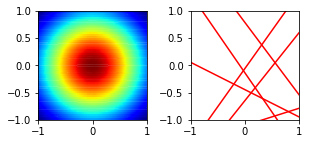

In [19]:
plt.figure(figsize=(5,2))

ax = plt.subplot(1, 2, 1)
q0 = prior.pdf(u_grid)
plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
plt.gca().set_aspect('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

ax = plt.subplot(1, 2, 2)
ws = prior.sample(6)
Y_plot = X_plot @ ws.T
for i in range(6):
  plt.plot(x_plot, Y_plot[:,i], c="r")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')

In [20]:
print(X[0], t[0])

tf.Tensor([ 1.         -0.57894737], shape=(2,), dtype=float64) tf.Tensor(-0.6417805319914437, shape=(), dtype=float64)


In [0]:
prior_mean = prior.mean()
prior_precision = tf.linalg.inv(prior.covariance())

posterior_precision = tf.math.add(prior_precision,
  beta * tf.linalg.matmul(tf.transpose(X[0,None]), X[0,None])) # 식 3,51

posterior_covariance = tf.linalg.inv(posterior_precision)
second_term = tf.math.add(
    tf.linalg.matvec(prior_precision, prior_mean), 
    beta * tf.linalg.matvec(tf.transpose(X[0,None]), t[0,None]))
posterior_mean = tf.linalg.matvec(posterior_covariance, second_term)

In [0]:
posterior = MultivariateGaussian(posterior_mean, posterior_covariance)

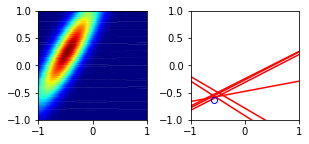

In [23]:
plt.figure(figsize=(5,2))

ax = plt.subplot(1, 2, 1)
q0 = posterior.pdf(u_grid)
plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
plt.gca().set_aspect('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

ax = plt.subplot(1, 2, 2)
ws = posterior.sample(6)
Y_plot = X_plot @ ws.T
for i in range(6):
  plt.plot(x_plot, Y_plot[:,i], c="r")
plt.plot(x[0], t[0], 'bo', markerfacecolor='none')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')

In [24]:
print(x[0], t[0])

tf.Tensor(-0.5789473652839661, shape=(), dtype=float64) tf.Tensor(-0.6417805319914437, shape=(), dtype=float64)


In [0]:
prior = posterior

In [0]:
prior_mean = prior.mean()
prior_precision = tf.linalg.inv(prior.covariance())

posterior_precision = tf.math.add(prior_precision,
  beta * tf.linalg.matmul(tf.transpose(X[1,None]), X[1,None])) # 식 3,51

posterior_covariance = tf.linalg.inv(posterior_precision)
second_term = tf.math.add(
    tf.linalg.matvec(prior_precision, prior_mean), 
    beta * tf.linalg.matvec(tf.transpose(X[1,None]), t[1,None]))
posterior_mean = tf.linalg.matvec(posterior_covariance, second_term)

In [0]:
posterior = MultivariateGaussian(posterior_mean, posterior_covariance)

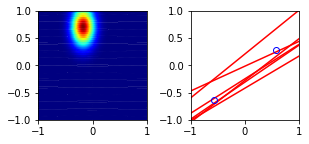

In [28]:
plt.figure(figsize=(5,2))

ax = plt.subplot(1, 2, 1)
q0 = posterior.pdf(u_grid)
plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
plt.gca().set_aspect('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

ax = plt.subplot(1, 2, 2)
ws = posterior.sample(6)
Y_plot = X_plot @ ws.T
for i in range(6):
  plt.plot(x_plot, Y_plot[:,i], c="r")
plt.plot(x[0:2], t[0:2], 'bo', markerfacecolor='none')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')

In [0]:
prior = posterior

In [0]:
prior_mean = prior.mean()
prior_precision = tf.linalg.inv(prior.covariance())

posterior_precision = tf.math.add(prior_precision,
  beta * tf.linalg.matmul(tf.transpose(X[2:]), X[2:])) # 식 3,51

posterior_covariance = tf.linalg.inv(posterior_precision)
second_term = tf.math.add(
    tf.linalg.matvec(prior_precision, prior_mean), 
    beta * tf.linalg.matvec(tf.transpose(X[2:]), t[2:]))
posterior_mean = tf.linalg.matvec(posterior_covariance, second_term)

In [0]:
posterior = MultivariateGaussian(posterior_mean, posterior_covariance)

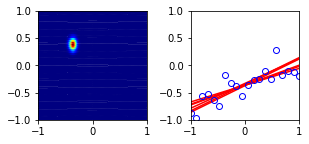

In [32]:
plt.figure(figsize=(5,2))

ax = plt.subplot(1, 2, 1)
q0 = posterior.pdf(u_grid)
plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
plt.gca().set_aspect('equal')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

ax = plt.subplot(1, 2, 2)
ws = posterior.sample(6)
Y_plot = X_plot @ ws.T
for i in range(6):
  plt.plot(x_plot, Y_plot[:,i], c="r")
plt.plot(x, t, 'bo', markerfacecolor='none')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')